# Use AutoAI and BatchedTreeEnsemble for incremental learning of AutoAI pipelines `ibm-watsonx-ai`

This notebook contains the steps and code to demonstrate support of AutoAI experiments in watsonx.ai Runtime service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines, refining pipelines, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:

-  Work with watsonx.ai Runtime experiments to train AutoAI models.
-  Compare trained models quality and select the best one for further refinement.
-  Refine the best model and test new variations.
-  Online deployment and score the trained model.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Create connection](#connection)
3. [Optimizer definition](#definition)
4. [Experiment Run](#run)
5. [Pipelines comparison and testing](#comparison)
6. [Incremental learning](#incremental)
7. [Deploy and Score](#scoring)
8. [Cleanup](#cleanup)
9. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage can be found <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**


### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install plotly | tail -n 1
!pip install matplotlib | tail -n 1 
!pip install -U autoai-libs | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install "scikit-learn==1.3.0" | tail -n 1

### Connection to watsonx.ai Runtime

Authenticate the watsonx.ai Runtime service on IBM Cloud. You need to provide Cloud `API key` and `location`.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the watsonx.ai Runtime docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance details.


You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve the instance `location`.

```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance INSTANCE_NAME
```


**NOTE:** You can also get a service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, and then copy the created key and paste it in the following cell.  


**Action**: Enter your `api_key` and `location` in the following cell.

In [ ]:
api_key = 'PUT_YOUR_KEY_HERE'
location = 'us-south'

In [1]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url='https://' + location + '.ml.cloud.ibm.com'
)

In [2]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

You need to create a space that will be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select watsonx.ai Runtime instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign space ID below

In [4]:
space_id = 'PUT_YOUR_SPACE_ID_HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in watsonx.ai Runtime, you need to set the **space** which you will be using.

In [5]:
client.set.default_space(space_id)

'SUCCESS'

<a id="connection"></a>
## 2. Connections to COS

Define connection information to COS bucket and training data CSV file. This example uses the German Credit Risk dataset. 

The dataset can be downloaded from [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/data/electricity/electricity.csv).

**Action**: Upload training data to COS bucket and enter location information below.

In [6]:
cos_credentials = client.spaces.get_details(space_id=space_id)['entity']['storage']['properties']

filename = 'electricity.csv'
datasource_name = 'bluemixcloudobjectstorage'
bucketname = cos_credentials['bucket_name']

Download training data from git repository.

In [7]:
import wget
import os

url = "https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/data/electricity/electricity.csv"
if not os.path.isfile(filename): 
    wget.download(url)

#### Create a connection

In [8]:
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {datasource_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(datasource_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucketname,
        'access_key': cos_credentials['credentials']['editor']['access_key_id'],
        'secret_key': cos_credentials['credentials']['editor']['secret_access_key'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': cos_credentials['endpoint_url']
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

Creating connections...
SUCCESS


In [9]:
from ibm_watsonx_ai.helpers import DataConnection, S3Location

connection_id = client.connections.get_id(conn_details)

electricity_conn = DataConnection(
    connection_asset_id=connection_id,
    location=S3Location(bucket=bucketname,
                        path=filename))

electricity_conn.set_client(client)
training_data_reference=[electricity_conn]
electricity_conn.write(data=filename, remote_name=filename)

<a id="definition"></a>
## 3. Optimizer definition

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [10]:
from ibm_watsonx_ai.experiment import AutoAI
from ibm_watsonx_ai.utils.autoai.enums import ClassificationAlgorithms as CA
from ibm_watsonx_ai.utils.autoai.enums import BatchedClassificationAlgorithms as BCA

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Electricity Prediction - AutoAI',
    prediction_type=AutoAI.PredictionType.CLASSIFICATION,
    prediction_column='class',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
    sample_size_limit=635897,
    sampling_type="first_n_records",
    retrain_on_holdout=True,
    include_only_estimators=[CA.EX_TREES, CA.LGBM, CA.RF, CA.SnapRF, CA.SnapBM, CA.XGB],
    include_batched_ensemble_estimators=[BCA.EX_TREES, BCA.LGBM, BCA.RF, BCA.SnapBM, BCA.SnapRF, BCA.XGB],
    use_flight=True,
    
)

Configuration parameters can be retrieved via `get_params()`.

In [ ]:
pipeline_optimizer.get_params()

<a id="run"></a>
## 4. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [11]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job bee18e3a-df2a-4e51-9eff-32b770f237dc completed: 100%|████████| [11:15<00:00,  6.75s/it]


In [ ]:
run_details

You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [12]:
pipeline_optimizer.get_run_status()

'completed'

<a id="comparison"></a>
## 5. Pipelines comparison and testing

You can list trained pipelines and evaluation metrics information in
the form of a Pandas DataFrame by calling the `summary()` method. You can
use the DataFrame to compare all discovered pipelines and select the one
you like for further testing.

In [13]:
summary = pipeline_optimizer.summary()
summary

,Enhancements,Estimator,training_roc_auc_(optimized),holdout_average_precision,holdout_log_loss,training_accuracy,holdout_roc_auc,training_balanced_accuracy,training_f1,holdout_precision,training_average_precision,training_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_2,HPO,LGBMClassifier,0.988957,1.000000,0.018826,0.950673,0.992602,0.949945,0.956949,1.000000,0.992137,0.133128,1.000000,0.959061,1.000000,1.000000,0.954854,1.000000
Pipeline_6,HPO,XGBClassifier,0.987003,1.000000,NaN,0.946647,0.991765,0.945293,0.953579,1.000000,0.990778,NaN,0.998031,0.952781,0.998869,0.999016,0.954416,0.999015
Pipeline_1,,LGBMClassifier,0.988060,0.998823,0.089263,0.950296,0.991545,0.949692,0.956587,0.997984,0.991600,0.142254,0.974409,0.959459,0.984163,0.985875,0.953758,0.986056
Pipeline_8,"HPO, FE, HPO",XGBClassifier,0.989324,0.997810,0.077726,0.946647,0.990495,0.944835,0.953705,0.956107,0.992313,0.131115,0.986220,0.950417,0.966063,0.962525,0.957046,0.970930
Pipeline_7,"HPO, FE",XGBClassifier,0.988618,0.997910,NaN,0.943878,0.990032,0.942042,0.951292,0.959693,0.991813,0.131826,0.984252,0.948201,0.967195,0.964200,0.954416,0.971817
Pipeline_3,"HPO, FE",LGBMClassifier,0.986517,0.997528,0.108367,0.943375,0.988548,0.942788,0.950493,0.984032,0.990526,0.151926,0.970472,0.954301,0.973982,0.974598,0.946746,0.977205
Pipeline_4,"HPO, FE, HPO",LGBMClassifier,0.986679,0.999707,0.050811,0.945011,0.985859,0.943945,0.952072,0.990157,0.990611,0.149818,0.990157,0.953059,0.988688,0.988430,0.951129,0.990157
Pipeline_5,,XGBClassifier,0.982262,0.993517,0.152945,0.932931,0.983242,0.929875,0.942109,0.962451,0.987030,0.179427,0.958661,0.933898,0.954751,0.954065,0.950471,0.960552


You can visualize the scoring metric calculated on a holdout data set.

In [14]:
import pandas as pd
pd.options.plotting.backend = "plotly"

summary.holdout_roc_auc.plot()

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [20]:
best_pipeline = pipeline_optimizer.get_pipeline()

### Convert the pipeline model to a Python script and download it

In [ ]:
from ibm_watsonx_ai.helpers import pipeline_to_script
pipeline_to_script(best_pipeline)

### Visualize pipeline

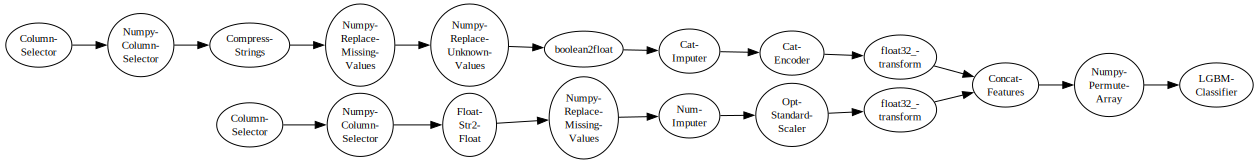

In [23]:
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.

### Pipeline source code

In [ ]:
best_pipeline.pretty_print(ipython_display=True, astype='sklearn')

In the pretty-printed code, `>>` is the pipe combinator (dataflow
edge) and `&` is the and combinator (combining multiple subpipelines).
They correspond to the `make_pipeline` and `make_union` functions from
scikit-learn, respectively. If you prefer the functions, you can
instead pretty-print your pipeline with
`best_pipeline.pretty_print(ipython_display=True, combinators=False)`.

### Reading training data from COS

In [25]:
train_df = pipeline_optimizer.get_data_connections()[0].read()

train_X = train_df.drop(['class'], axis=1).values
train_y = train_df['class'].values

### Test pipeline model locally

In [26]:
predicted_y = best_pipeline.predict(train_X)
predicted_y[:5]

array([0., 0., 0., 0., 1.])

<a id="incremental"></a>
## 6. Incremental learning of BatchedTreeEnsemble pipelines

In this section you learn to train AutoAI models incrementally.

### Data loader

Create DataLoader iterator to retrieve training dataset in batches (Pandas DataFrame). DataLoader is `Torch` compatible (`torch.utils.data`).

**Note**: If reading data results in an error, provide data as batches (Pandas DataFrame). It may be necessary to use methods for initial data pre-processing like: e.g. `DataFrame.dropna()`, `DataFrame.drop_duplicates()`, `DataFrame.sample()`.

In [ ]:
from ibm_watsonx_ai.data_loaders import experiment as data_loaders
from ibm_watsonx_ai.data_loaders.datasets import experiment as datasets

dataset = datasets.ExperimentIterableDataset(
    connection=training_data_reference[0],
    with_subsampling=False,
    experiment_metadata = {"prediction_type":"classification"},
    number_of_batch_rows=9062,
    _wml_client = client
)

data_loader = data_loaders.ExperimentDataLoader(dataset=dataset)

### Continue model training

In [28]:
from sklearn.metrics import get_scorer

scorer = get_scorer(AutoAI.Metrics.ROC_AUC_SCORE)

In [29]:
run_id = run_details['metadata']['id']

### Fit pipeline model in batches (`partial_fit`)
In this cell, the pipeline is incrementally fitted using data batches.


**Note**: You can also use custom code for data reading and model training. The `pipeline` supports incremental learning via `partial_fit` calls.

If you need, you can evaluate the pipeline using custom holdout data. Provide the `X_test`, `y_test` and call `scorer` on them.

In [30]:
best_pipeline.steps[-1][-1].impl.max_sub_ensembles = 5

In [33]:
i = 0
iters = []
partial_fit_scores = []

for batch_df in data_loader:
    X_train = batch_df.drop(['class'], axis=1).values
    y_train = batch_df['class'].values
    pipeline_model = best_pipeline.partial_fit(X_train, y_train, classes=pd.unique(train_y).tolist(), freeze_trained_prefix=True)
    pipeline_score = scorer(pipeline_model, X_train, y_train)
    partial_fit_scores.append(pipeline_score)
    print('Pipeline - batch: {0} | score: {1}'.format(iter, pipeline_score))

Pipeline - batch: <built-in function iter> | score: 0.9995922775542677
Pipeline - batch: <built-in function iter> | score: 0.9989746768078582
Pipeline - batch: <built-in function iter> | score: 0.9995701248005769
Pipeline - batch: <built-in function iter> | score: 0.9993587988263039
Pipeline - batch: <built-in function iter> | score: 1.0


In [38]:
import plotly.graph_objs as go

y_values = partial_fit_scores
x_labels = list(range(len(y_values)))

trace = go.Scatter(
    x=x_labels,
    y=y_values,
    mode='lines+markers',
    marker=dict(color='blue', size=8),
    line=dict(color='blue', width=2),
    name='Data Points'
)

layout = go.Layout(
    title='AutoAI incremental learning curve',
    yaxis=dict(title='BatchedEnsemble')
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()

Test the fitted pipeline (`predict`).

In [39]:
pipeline_model.predict(train_X)

array([1., 1., 1., ..., 1., 1., 1.])

<a id="cleanup"></a>
## 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps

 You successfully completed this notebook!.
 
 You learned how to use `ibm-watsonx-ai` to run AutoAI experiments. 
 
 Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Szymon Kucharczyk**, Staff Software Engineer at watsonx.ai

**Mateusz Szewczyk**, Software Engineer at watsonx.ai

Copyright © 2022-2025 IBM. This notebook and its source code are released under the terms of the MIT License.